In [177]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, roc_auc_score
from scipy import stats

Loading the Data and Checking for Null Values

In [178]:
training_data = pd.read_excel('recruiting_zeta-disease_training-data_take-home-challenge.xlsx')
training_data.isnull().any()

age                   False
weight                False
bmi                   False
blood_pressure        False
insulin_test          False
liver_stress_test     False
cardio_stress_test    False
years_smoking         False
zeta_disease          False
dtype: bool

In [179]:
#Filtering out bad data related to smoking, and then filtering outliers
#(This ended up making performance worse so I commented it out)
training_data = training_data[training_data['years_smoking'] < training_data['age']]
# training_data = training_data[(np.abs(stats.zscore(training_data)) < 3).all(axis=1)]

# Feature Engineering Steps

In [180]:
#Creating new categorical columns around age, bmi, and smoking history in addition to creating fat
bins = [17, 35, 50, 65, float("inf")]
training_data['age_group'] = pd.cut(training_data['age'], bins=bins, labels=['young_adult', 'middle_age', 'older_adult', 'seniors'])
bins = [0, 18.5, 25, 30, float("inf")]
training_data['bmi_category'] = pd.cut(training_data['age'], bins=bins, labels=['underweight', 'normal_weight', 'overweight', 'obese'])
training_data['smoking_ratio'] = training_data['years_smoking']/training_data['age']
training_data['total_stress'] = training_data['cardio_stress_test'] + training_data['liver_stress_test']
training_data['smoking_bp'] = training_data['years_smoking'] * training_data['blood_pressure']
training_data['insulin_weight'] = training_data['insulin_test'] * training_data['weight']
bins = [0, 0.1, 5, 20, float("inf")]
training_data['smoking_risk'] = pd.cut(training_data['years_smoking'], include_lowest=True, bins=bins, labels=['non-smoker','light_smoker', 'medium_smoker', 'heavy_smoker'])
num_cols = ['age', 'weight', 'bmi', 'blood_pressure','insulin_test','liver_stress_test','cardio_stress_test', 'years_smoking', 'smoking_ratio', 'total_stress', 'smoking_bp', 'insulin_weight']
cat_cols = ['age_group', 'bmi_category', 'smoking_risk']

In [181]:
training_data['zeta_disease'].value_counts()

zeta_disease
0    519
1    279
Name: count, dtype: int64

Creating a correlation matrix to visualize any collinearity

<Axes: >

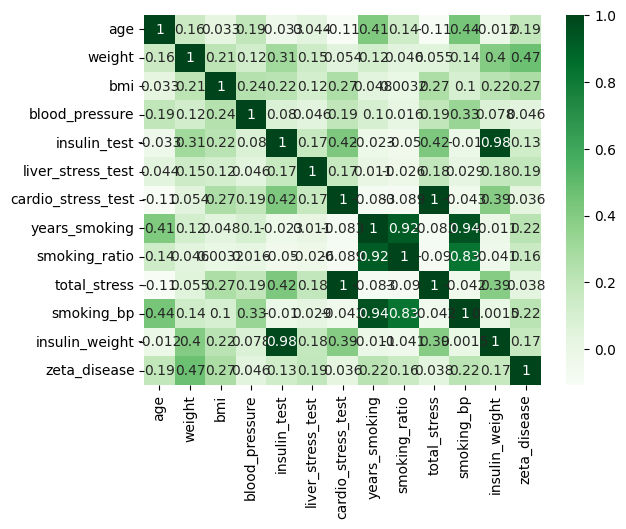

In [182]:
import seaborn as sns
correlation = training_data[num_cols + ['zeta_disease']].corr()
sns.heatmap(correlation, cmap="Greens", annot=True)

Plotting distribution of each feature

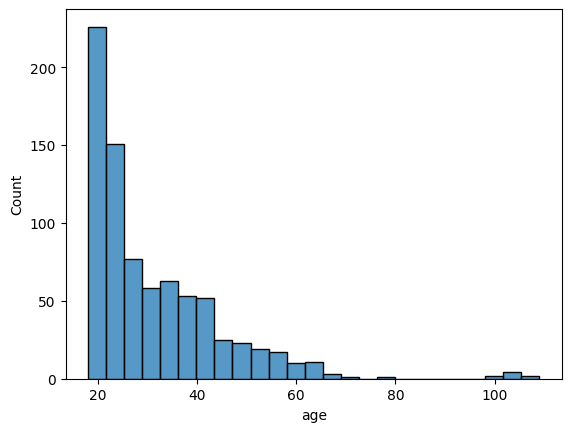

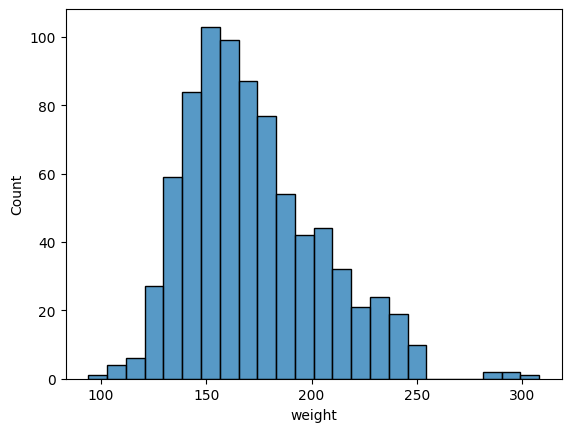

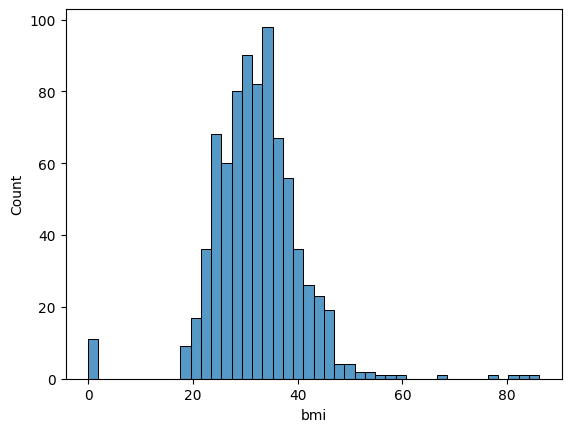

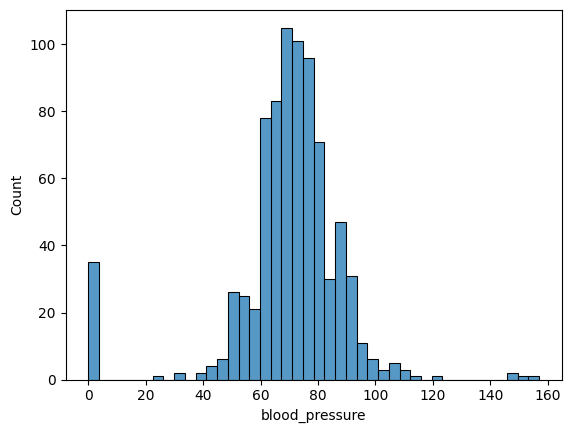

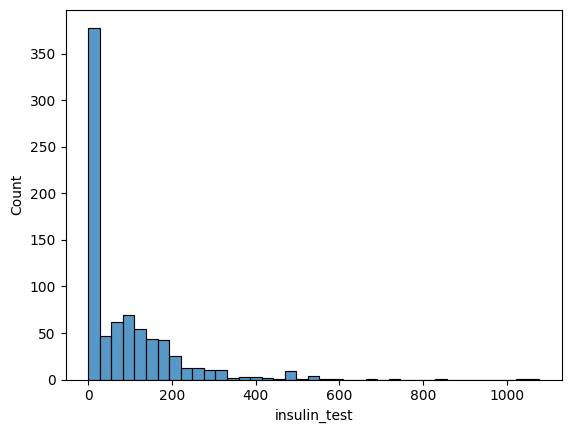

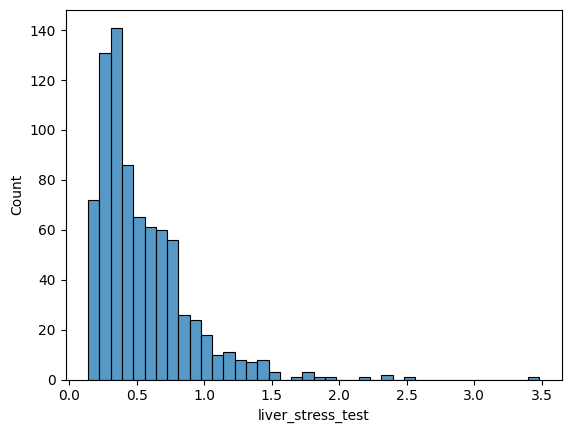

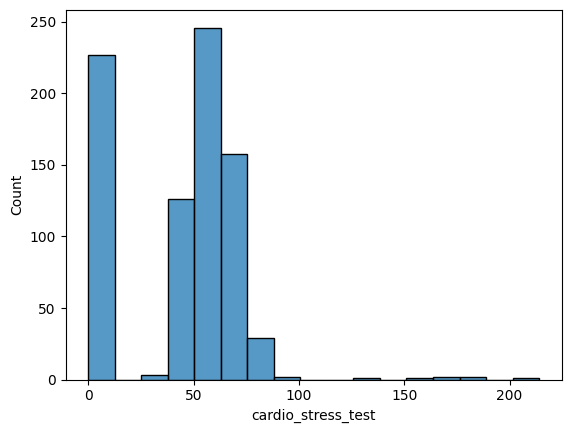

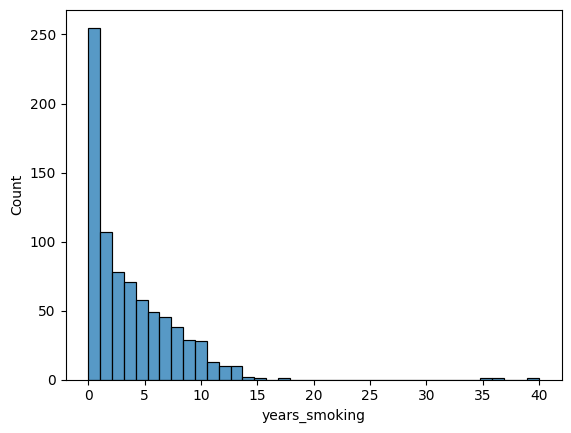

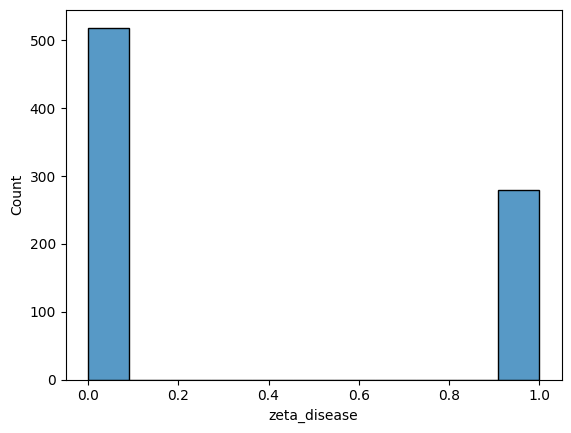

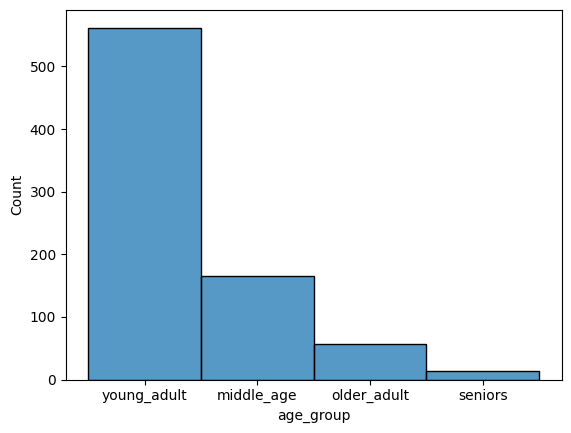

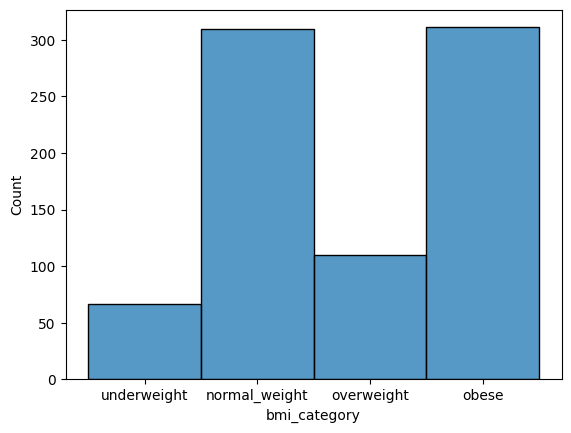

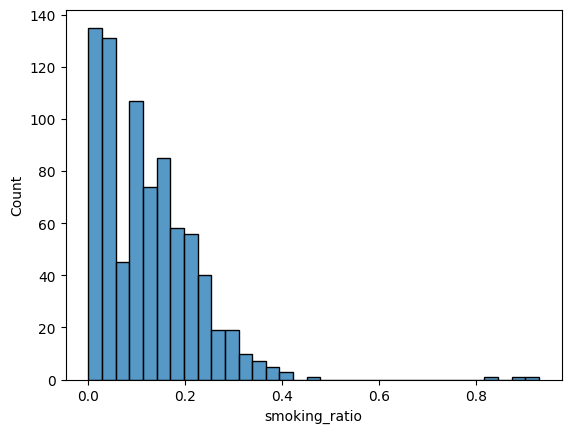

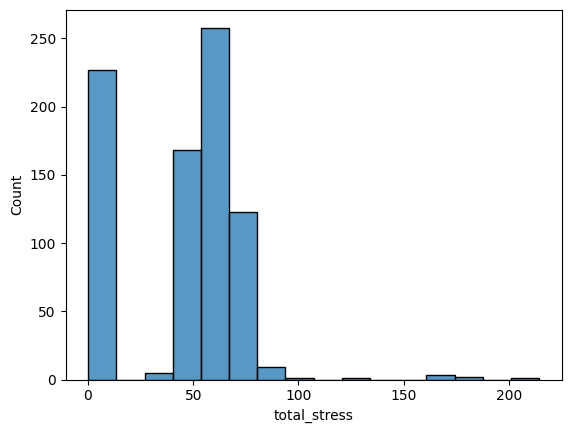

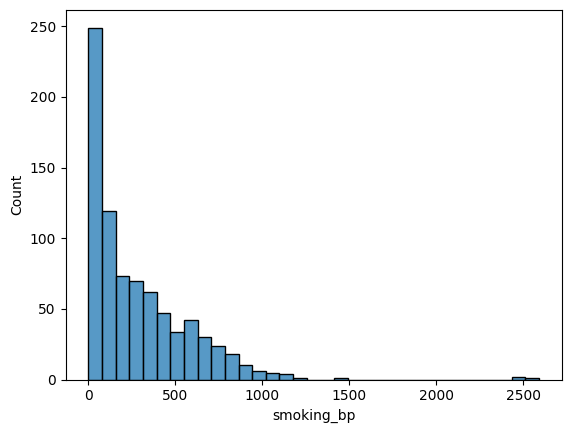

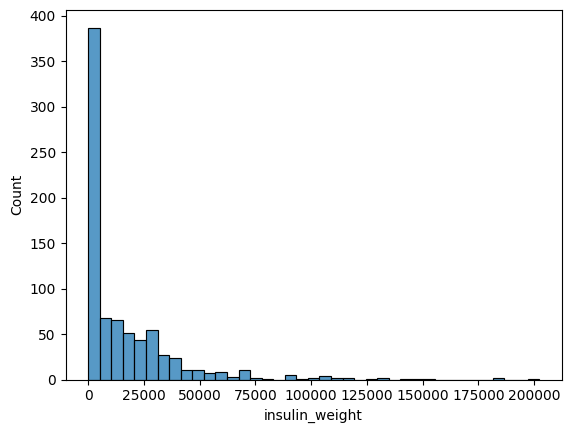

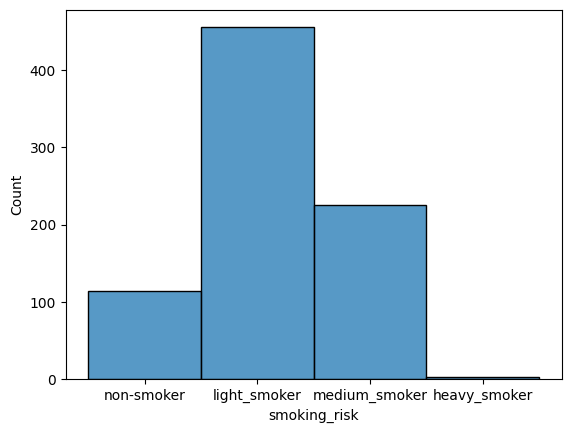

In [183]:
from matplotlib import pyplot as plt
for col in training_data.columns:
    sns.histplot(training_data[col])
    plt.show()

Scaling numerical features and One-Hot encoding categorical features

In [184]:

X = training_data.drop('zeta_disease', axis='columns')
y = training_data['zeta_disease']
scaler = MinMaxScaler()
encoder = OneHotEncoder()
transformer = ColumnTransformer(transformers=[('min-max', scaler, num_cols), ('one-hot', encoder, cat_cols)])

X_transform = transformer.fit_transform(X)

Stratified train test split so that we can validate our data

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.2, stratify=y)

Utilizing GridSearch to optimize hyperparameters

In [186]:
model = LogisticRegressionCV(cv=5, scoring='f1', class_weight='balanced')
params = {'Cs': [10, 20, 30], 'solver': ['liblinear', 'lbfgs', 'newton-cholesky'], 'max_iter':[150, 250, 500]}
grid_search = GridSearchCV(model, param_grid=params, refit=True, return_train_score=True)
grid_search.fit(X_train, y_train)
zeta_log_model = grid_search.best_estimator_
print(grid_search.best_params_, grid_search.best_score_)

{'Cs': 20, 'max_iter': 150, 'solver': 'liblinear'} 0.679076047998886


In [187]:
y_pred = zeta_log_model.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(f1_score(y_pred, y_test))
print(recall_score(y_pred, y_test))
print(precision_score(y_pred, y_test))
print(roc_auc_score(y_pred, y_test))


[[89 18]
 [15 38]]
0.6972477064220184
0.7169811320754716
0.6785714285714286
0.7743784165050255


In [188]:
pred_data = pd.read_excel('recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx')
pred_data.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.0
mean,34.750000,178.800000,34.480000,78.500000,145.050000,1.569600,61.950000,6.050000,NaN
std,11.511436,27.935264,6.628773,14.005638,75.964309,0.230356,9.703363,3.471311,NaN
min,19.000000,120.000000,25.800000,59.000000,50.000000,1.249800,43.000000,2.000000,NaN
25%,26.250000,153.250000,30.250000,69.750000,76.250000,1.411800,55.750000,3.000000,NaN
50%,34.500000,188.500000,33.150000,72.500000,137.000000,1.483300,60.000000,5.500000,NaN
75%,44.250000,197.750000,37.600000,89.250000,167.750000,1.737800,68.000000,7.500000,NaN
max,60.000000,216.000000,50.700000,108.000000,362.000000,2.050800,83.000000,13.000000,NaN


In [189]:
bins = [17, 35, 50, 65, float("inf")]
pred_data['age_group'] = pd.cut(pred_data['age'], bins=bins, labels=['young_adult', 'middle_age', 'older_adult', 'seniors'])
bins = [0, 18.5, 25, 30, float("inf")]
pred_data['bmi_category'] = pd.cut(pred_data['age'], bins=bins, labels=['underweight', 'normal_weight', 'overweight', 'obese'])
pred_data['smoking_ratio'] = pred_data['years_smoking']/pred_data['age']
pred_data['total_stress'] = pred_data['cardio_stress_test'] + pred_data['liver_stress_test']
pred_data['smoking_bp'] = pred_data['years_smoking'] * pred_data['blood_pressure']
pred_data['insulin_weight'] = pred_data['insulin_test'] * pred_data['weight']
bins = [0, 0.1, 5, 10, float("inf")]
pred_data['smoking_risk'] = pd.cut(pred_data['years_smoking'], include_lowest=True, bins=bins, labels=['non-smoker','light_smoker', 'medium_smoker', 'heavy_smoker'])

In [190]:
pred_data = pred_data.drop('zeta_disease', axis=1)
pred_data_transformed = transformer.transform(pred_data)

pred_data['zeta_disease'] = zeta_log_model.predict(pred_data_transformed)



In [191]:
pred_data

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,age_group,bmi_category,smoking_ratio,total_stress,smoking_bp,insulin_weight,smoking_risk,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,young_adult,normal_weight,0.166667,57.3968,276,10872,light_smoker,0
1,27,179,35.5,89,156,1.6608,43,6,young_adult,overweight,0.222222,44.6608,534,27924,medium_smoker,1
2,34,147,26.9,76,74,1.6958,53,2,young_adult,obese,0.058824,54.6958,152,10878,light_smoker,0
3,35,206,32.4,73,127,1.4608,61,6,young_adult,obese,0.171429,62.4608,438,26162,medium_smoker,1
4,60,193,29.8,62,192,1.7798,65,9,older_adult,obese,0.150000,66.7798,558,37056,medium_smoker,1
5,45,120,36.5,108,50,1.2978,54,12,middle_age,obese,0.266667,55.2978,1296,6000,heavy_smoker,1
6,20,139,38.2,61,77,1.5818,68,3,young_adult,normal_weight,0.150000,69.5818,183,10703,light_smoker,0
7,23,137,31.2,70,73,1.4168,59,7,young_adult,normal_weight,0.304348,60.4168,490,10001,medium_smoker,0
8,36,195,30.5,59,141,1.4498,59,6,middle_age,obese,0.166667,60.4498,354,27495,medium_smoker,1
9,19,193,25.8,84,66,1.7938,50,3,young_adult,normal_weight,0.157895,51.7938,252,12738,light_smoker,1
